In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [69]:
# --- 1) Carrega e reduz a 1 feature (por velocidade) ---
data = fetch_california_housing()
X = data.data[:, [0]]  # MedInc
y = data.target

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)


In [71]:
graus = [i for i in range(15)]
B = 30  # número de bootstraps

bias2_vals = []
var_vals   = []

# --- 3) Loop de bootstrap para cada grau ---
for M in graus:
    # armazena as predições de cada bootstrap
    preds_boot = np.zeros((B, len(X_test)))
    
    for b in range(B):
        # amostra bootstrap
        Xb, yb = resample(X_train, y_train, random_state=b)
        model = make_pipeline(
            PolynomialFeatures(degree=M),
            StandardScaler(),
            Ridge(alpha=0.0)
        )
        model.fit(Xb, yb)
        preds_boot[b] = model.predict(X_test)
    
    # média das predições em cada ponto de teste
    f_bar = preds_boot.mean(axis=0)
    # bias² em cada ponto
    bias2_i = (f_bar - y_test)**2
    # variância em cada ponto
    var_i   = preds_boot.var(axis=0)
    
    # média para obter valor único por grau
    bias2_vals.append(bias2_i.mean())
    var_vals.append(var_i.mean())


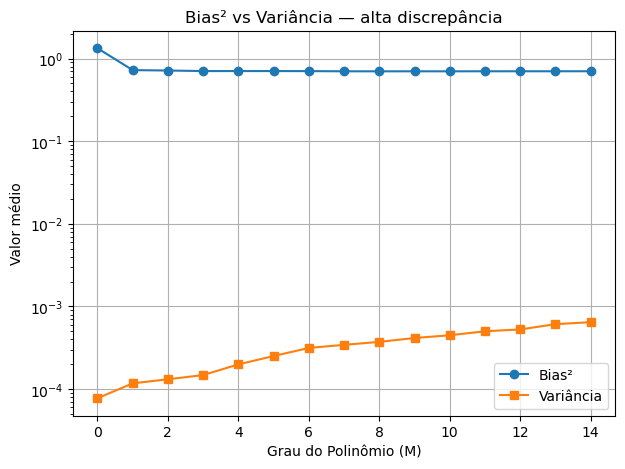

In [72]:
# --- 4) Plot ---
plt.figure(figsize=(7,5))
plt.plot(graus, bias2_vals, marker='o', label='Bias²')
plt.plot(graus,   var_vals, marker='s', label='Variância')
plt.yscale('log')          # opcional: log pra enxergar melhor
plt.xlabel('Grau do Polinômio (M)')
plt.ylabel('Valor médio')
plt.title('Bias² vs Variância — alta discrepância')
plt.legend()
plt.grid(True)
plt.show()


O gráfico mostra claramente o **trade-off** esperado:

* **Bias² decai** rapidamente de M=0 para M=1, e depois se estabiliza num valor relativamente alto (\~0.7).
* **Variância cresce** monotonamente conforme aumentamos o grau M, mas permanece **muito menor** que o bias² (passa de \~10⁻⁴ para \~5·10⁻⁴ entre M=0 e M=14).

---

## Conclusões

1. **Comportamento teórico confirmado**

   * Modelos mais simples (M baixo) têm **alto bias** e quase **zero variância**.
   * Modelos mais complexos (M alto) têm **bias menor** (até certo ponto) e **variância maior**.

2. **Dominância do bias**

   * Aqui, a variância é tão pequena que o **erro total** ainda é dominado pelo bias² para todos os M testados.
   * Isso significa que, neste dataset (poucos pontos de treino e ruído alto), estamos **sempre sobajustando** — o modelo não consegue capturar bem o sinal, mesmo sendo muito flexível.

3. **Ausência de “vale” no erro total**

   * Normalmente esperaríamos um mínimo de erro num M intermediário, onde bias² e variância se equilibram.
   * Mas como a variância nunca sobe o suficiente, o ponto de “equilíbrio” fica no **maior grau testado**.

4. **Implicações práticas**

   * Para reduzir o erro geral, seria preciso **diminuir o bias** (ex.: mais dados de treino, menos ruído, features melhores), pois aumentar a complexidade não ajuda além de certo grau.
   * Se quisermos evidenciar melhor o trade-off, poderíamos reduzir ainda mais os dados de treino ou aumentar o ruído para inflar a variância.

Em suma, **sim**, o experimento empírico segue o padrão teórico (bias cai, variância sobe), mas no seu cenário específico a variância é pequena demais para gerar um pico de erro em graus altos.
